In [1]:
from humpback import *

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

2024-08-12 13:08:44.713220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def preprocess(
    data_df: pd.DataFrame,
    train_size: float,
    val_size: float,
    test_size: float,
    scale: bool):
    """Splits data into train/val/test sets and scales the data.

    Args:
        data_df: DataFrame of shape `(num_time_steps, num_features)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.
        test_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the test split.

    Returns:
        `train_df`, `val_df`, `test_df`
    """

    if train_size + val_size + test_size != 1:
        raise Exception("train_size + val_size + test_size != 1")

    train_df, val_test_df = train_test_split(
        data_df,
        train_size=train_size,
        shuffle=False)

    val_df, test_df = train_test_split(
        val_test_df,
        train_size=(val_size/(val_size+test_size)),
        shuffle=False
    )

    scaler = MinMaxScaler()
    scaler = scaler.fit(train_df)
    
    # if scale:
        # for df in (train_df, val_df, test_df):
        #     df = pd.DataFrame(
        #         scaler.transform(df),
        #         index=df.index,
        #         columns=df.columns)

    train_df = pd.DataFrame(
        scaler.transform(train_df),
        index=train_df.index,
        columns=train_df.columns)

    val_df = pd.DataFrame(
        scaler.transform(val_df),
        index=val_df.index,
        columns=val_df.columns)

    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index=test_df.index,
        columns=test_df.columns)


    return train_df, val_df, test_df, scaler

In [3]:
class LSTM_stack(layers.Layer):
    """stacks of LSTM with dropout, follwed by dense layer"""

    def __init__(
        self,
        dropout_rate: float = 0.2
        ):
        super().__init__()

        self.lstm_1 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_2 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_3 = layers.LSTM(
            units=50,
            return_sequences=False,
            )

        self.dense_1 = layers.Dense(
            units=1
            )

        self.dropout_1 = layers.Dropout(dropout_rate)

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.dropout_1(x)
        x = self.lstm_2(inputs)
        x = self.dropout_1(x)
        x = self.lstm_3(inputs)
        x = self.dropout_1(x)
        return self.dense_1(x)

## Fetch Data

In [4]:
client = connectBinanceAPI()

In [5]:
symbol = 'BTCUSDT'
interval = '1h'

start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_str   = int(datetime(2021,12,31,0,0).timestamp() * 1000)

train_size, val_size, test_size = 0.5, 0.2, 0.3

batch_size = 64
input_sequence_length = 20
forecast_horizon = 1
multi_horizon = False


In [6]:
data_raw_df = getBinanceData(
    client=client,symbol=symbol,
    interval=interval,
    start_str=start_str,
    end_str=end_str
    )

In [7]:
data_df = getReturn(data_raw_df, 'Close')
data_df = featureGeneration(data_df)
X_data_df , y_data_df  = getXy(data_df , 'Return')

/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/humpback.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = sma(data, window) / data['Close']
/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/humpback.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = sma(data, window) / data['Close']
/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/humpback.py:94: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [8]:
X_train_df, X_val_df, X_test_df, X_scaler = preprocess(X_data_df, train_size, val_size, test_size, True)
y_train_df, y_val_df, y_test_df, y_scaler = preprocess(y_data_df, train_size, val_size, test_size, True)

In [9]:
train_dataset = keras.utils.timeseries_dataset_from_array(
        X_train_df,
        y_train_df,
        sequence_length=input_sequence_length,
        shuffle=False,
    )

In [10]:
val_dataset = keras.utils.timeseries_dataset_from_array(
        X_val_df,
        y_val_df,
        sequence_length=input_sequence_length,
        shuffle=False,
    ) 

In [11]:
test_dataset = keras.utils.timeseries_dataset_from_array(
        X_test_df,
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
    ) 

## Model

In [12]:
inputs  = keras.Input((
    input_sequence_length,
    X_train_df.shape[1]))
outputs = LSTM_stack()(inputs)
model   = keras.Model(inputs, outputs)

In [13]:
optimizer = keras.optimizers.Adam()
loss      = keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer,loss=loss)

In [14]:
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
    )

Epoch 1/20


/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0956 - val_loss: 0.1048
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0296 - val_loss: 0.0290
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0104 - val_loss: 0.0167
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0052 - val_loss: 0.0068
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0020 - val_l

In [15]:
predictions = pd.DataFrame(model.predict(test_dataset), index=y_test_df.iloc[input_sequence_length-1:,].index)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


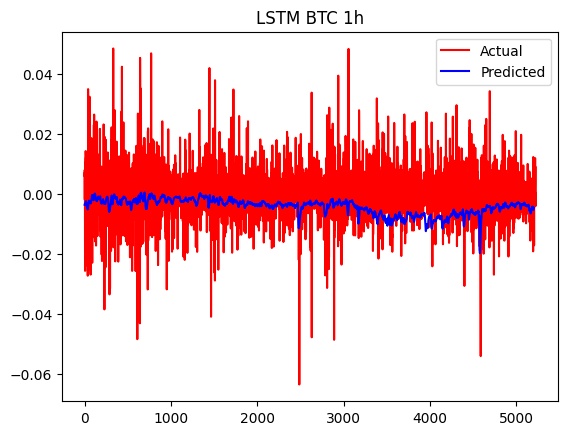

In [17]:
plt.plot(y_scaler.inverse_transform(y_test_df), color='red', label='Actual')
plt.plot(y_scaler.inverse_transform(predictions), color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 